# 通过seg模型将疑似SWD的object标注出来。

In [ ]:
# 读取yaml文件
import yaml
def read_yaml(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)
    return data

# 展示读取的数据
if __name__ == "__main__":
    file_path = 'example.yaml'  # 替换为你的yaml文件路径
    data = read_yaml(file_path)
    display(data)

{'name': 'John Doe',
 'age': 30,
 'occupation': 'Software Developer',
 'database': {'host': 'localhost',
  'port': 5432,
  'user': 'admin',
  'password': 'secret'},
 'cities': ['Chicago', 'Columbia', 'St Louis'],
 'models': [{'name': 'yolov11n-seg', 'type': 'seg', 'version': 1.2},
  {'name': 'yolov11n-pose', 'type': 'pose', 'version': 1.1}],
 'paths': {'input_dirs': ['/data/raw', '/data/clean'],
  'output_dir': '/data/output'},
 'training': {'epochs': 100,
  'batch_size': 16,
  'optimizer': {'type': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001}},
 'description': 'This is a long text.\nLine 2 will still be a new line.\nLine 3 keeps indentation.\n',
 'summary': 'This is a long sentence that will be folded into a single line after loading.\n',
 'title': 'Best Model: YOLOv11',
 'path': 'C:\\Users\\TQ\\data\\images'}

In [7]:
# 读取yaml文件
from sys import version
import yaml
from dataclasses import dataclass

def read_yaml(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)
    return data

# # 展示读取的数据
# if __name__ == "__main__":
#     file_path = 'run.yaml'  # 替换为你的yaml文件路径
#     data = read_yaml(file_path)
#     display(data)
# config oop
@dataclass
class Config:
    version: str
    run_type: str
    steps_to_run: list

def load_config(file_path) -> Config:
    data = read_yaml(file_path)
    return Config(
        version=data.get('version', ''),
        run_type=data.get('run_type', ''),
        steps_to_run=data.get('steps_to_run', [])
    )

# 展示读取的数据
if __name__ == "__main__":
    file_path = 'run.yaml'  # 替换为你的yaml文件路径
    config = load_config(file_path)
    display(config)

Config(version='v1.0', run_type='pose_and_det', steps_to_run=['run_clean_and_slice_images_on_dirs', 'process_sliced_images_with_yolo_seg', 'combine_sliced_predictions'])

In [ ]:
version = "v1"
run_type = "pose_and_det"  # "pose_and_det" or "cls"

# 需要运行的step列表
steps_to_run = [
    "run_clean_and_slice_images_on_dirs",           # Step 1 清理坏图并切片大图到640*640小图
    "process_sliced_images_with_yolo_seg",          # Step 2 使用YOLO-seg模型处理640*640切片图像
    "combine_sliced_predictions",                   # Step 3 合并seg预测结果，回到原图。 同时切出objects小图
]

# Step_0 查看根目录下需要运行的文件夹 
选择含有 raw_data 图片的 *_data 目录

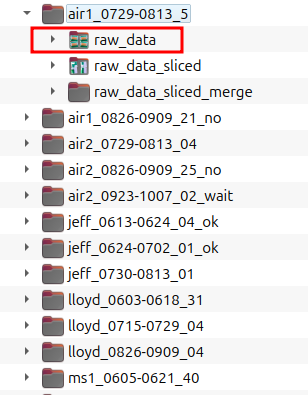


In [4]:
# 选择数据目录的核心代码
from pathlib import Path

def select_data_dirs(root_dir: Path, end_with: str = "_data"):
    # === 1) 遍历所有子目录 ===
    sub_dirs = list(root_dir.glob("*/*" + end_with))

    if not sub_dirs:
        print(f"没有找到 *{end_with} 目录")
        return []

    print(f"找到以下 {end_with} 数据集：")
    for i, d in enumerate(sub_dirs):
        print(f"[{i}] {d}")

    # === 2) 让用户选择要跑的目录 ===
    idx_str = input("请输入要处理的编号 (多个用逗号分隔, 回车默认全选): ").strip()
    if idx_str:
        indices = [int(x) for x in idx_str.split(",")]
        chosen_dirs = [sub_dirs[i] for i in indices]
    else:
        chosen_dirs = sub_dirs

    print(f"将处理以下 {end_with} 目录：")
    for i, d in enumerate(chosen_dirs):
        print(f"- {i+1}. {d}")

    # === 3) 筛选掉没有 raw_data 图片的目录 ===
    chosen_dirs = [
        d for d in chosen_dirs
        if (d.parent / "raw_data").exists() and any((d.parent / "raw_data").glob("*.jpg"))
    ]

    if not chosen_dirs:
        print(f"没有找到包含图片的 *{end_with} 目录")
        return []

    return chosen_dirs

In [5]:
root_dir = Path("/workspace/models/SAHI/run_v8")
chosen_dirs = select_data_dirs(root_dir, end_with="_data")
print("最终确认的目录：", chosen_dirs)
if not chosen_dirs:
    raise ValueError("没有选择任何目录，程序终止。")

找到以下 _data 数据集：
[0] /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
将处理以下 _data 目录：
- 1. /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
最终确认的目录： [PosixPath('/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data')]


# Step_1 将文件夹中的RAW图片全部切片640x640并保存

### 输入
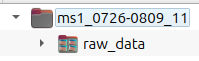

### 输出
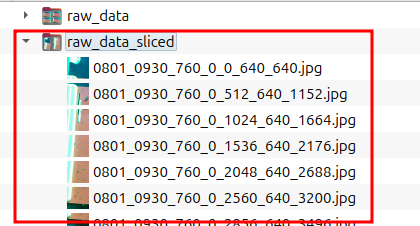

In [ ]:
# Step 1 清理坏图并切片

import os
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, Any, List, Optional, Tuple

import numpy as np
import cv2

# ============================================================
# 基本配置
# ============================================================
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")


# ============================================================
# 1) 单张图无损切片（输出 PNG）
# ============================================================
def slice_image_cv2(
    image_path: Path,
    output_dir: Path,
    tile_h: int = 640,
    tile_w: int = 640,
    overlap: float = 0.2,
    out_ext: str = ".jpg",           # ✅ JPG：有损
    jpeg_quality: int = 95,          # 对 PNG 无效，保留参数便于兼容
    png_compression: int = 3,        # 0(最快,大)~9(最慢,小)，3~5 较均衡
    keep_small_edge: bool = True,    # 末端不足一片时仍保存小片
) -> int:
    """
    读取一张图并切片到 output_dir，返回保存的切片数。
    文件命名：<stem>_x0_y0_x1_y1.<ext>（与 SAHI 基本兼容）
    """
    # 读图：np.fromfile + imdecode 更稳更快（兼容中文路径等）
    buf = np.fromfile(str(image_path), dtype=np.uint8)
    if buf.size == 0:
        return 0
    img = cv2.imdecode(buf, cv2.IMREAD_COLOR)
    if img is None:
        return 0

    H, W = img.shape[:2]
    out_ext = out_ext.lower()
    os.makedirs(output_dir, exist_ok=True)

    # 步长（带重叠）
    overlap = max(0.0, min(0.99, overlap))
    sh = max(1, int(round(tile_h * (1.0 - overlap))))
    sw = max(1, int(round(tile_w * (1.0 - overlap))))

    # 生成起点，确保右/下边缘覆盖
    ys = list(range(0, max(1, H - tile_h + 1), sh))
    xs = list(range(0, max(1, W - tile_w + 1), sw))
    if keep_small_edge:
        if ys[-1] != max(0, H - tile_h):
            ys.append(max(0, H - tile_h))
        if xs[-1] != max(0, W - tile_w):
            xs.append(max(0, W - tile_w))

    # 写图参数
    if out_ext in (".jpg", ".jpeg"):
        imwrite_params = [cv2.IMWRITE_JPEG_QUALITY, int(jpeg_quality)]
    elif out_ext == ".png":
        imwrite_params = [cv2.IMWRITE_PNG_COMPRESSION, int(png_compression)]
    else:
        imwrite_params = []

    stem = image_path.stem
    saved = 0

    for y0 in ys:
        y1 = min(y0 + tile_h, H)
        for x0 in xs:
            x1 = min(x0 + tile_w, W)
            crop = img[y0:y1, x0:x1]
            out_name = f"{stem}_{x0}_{y0}_{x1}_{y1}{out_ext}"
            out_path = output_dir / out_name
            try:
                cv2.imwrite(str(out_path), crop, imwrite_params)
                saved += 1
            except Exception:
                pass
    return saved


# ============================================================
# 2) 文件夹批量切片（并行按“图”）
# ============================================================
def slice_folder_cv2(
    input_folder: Path,
    output_folder: Optional[Path] = None,
    tile_h: int = 640,
    tile_w: int = 640,
    overlap: float = 0.2,
    out_ext: str = ".jpg",           # ✅ 默认 JPG：有损
    jpeg_quality: int = 95,
    png_compression: int = 3,
    recurse: bool = False,
    max_workers: Optional[int] = None,
) -> Dict[str, int]:
    """
    批量切图；返回 {'images':N, 'tiles':M, 'failed':K}
    """
    if output_folder is None:
        output_folder = input_folder.parent / f"{input_folder.name}_sliced"
    output_folder.mkdir(parents=True, exist_ok=True)

    it = input_folder.rglob("*") if recurse else input_folder.iterdir()
    images = [p for p in it if p.is_file() and p.suffix.lower() in IMG_EXTS]
    if not images:
        print(f"[slice] no images in {input_folder}")
        return {"images": 0, "tiles": 0, "failed": 0}

    if max_workers is None:
        cpu = os.cpu_count() or 8
        max_workers = max(2, min(16, cpu * 4))  # 留出余量，封顶 16

    def _one(p: Path) -> Tuple[Path, int]:
        try:
            return p, slice_image_cv2(
                p, output_folder,
                tile_h=tile_h, tile_w=tile_w, overlap=overlap,
                out_ext=out_ext, jpeg_quality=jpeg_quality, png_compression=png_compression
            )
        except Exception:
            return p, 0

    tiles = failed = 0

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(_one, p) for p in images]
        for fut in as_completed(futures):
            _, saved = fut.result()
            tiles += saved
            if saved == 0:
                failed += 1

    print(f"[slice] images={len(images)} tiles={tiles} failed={failed} -> {output_folder}")
    return {"images": len(images), "tiles": tiles, "failed": failed}


# ============================================================
# 3) 快速删除坏图（并行）
# ============================================================
def delete_corrupt_images_fast(
    root_dir: Path | str,
    recurse: bool = False,
    exts: Tuple[str, ...] = (".jpg", ".jpeg", ".png"),  # 主要 JPG/PNG
    min_bytes: int = 32,                                # 小于这个大小直接判坏图
    max_workers: Optional[int] = None,                  # 默认=CPU*4
    dry_run: bool = False,                              # 仅统计不删除
) -> Dict[str, int]:
    root = Path(root_dir)
    if recurse:
        files = [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]
    else:
        files = [p for p in root.iterdir() if p.is_file() and p.suffix.lower() in exts]

    if max_workers is None:
        cpu = os.cpu_count() or 8
        max_workers = max(2, min(16, cpu * 4))  # 留出余量，封顶 16

    def is_bad(p: Path) -> Tuple[Path, bool, str]:
        # 1) 空/超小文件：直接坏
        try:
            if p.stat().st_size < min_bytes:
                return p, True, "too_small"
        except Exception:
            return p, True, "stat_error"

        # 2) OpenCV 高速解码校验
        try:
            data = np.fromfile(str(p), dtype=np.uint8)
            if data.size == 0:
                return p, True, "empty"
            img = cv2.imdecode(data, cv2.IMREAD_UNCHANGED)
            if img is None:
                return p, True, "imdecode_none"
            h, w = img.shape[:2]
            if h == 0 or w == 0:
                return p, True, "zero_dim"
            return p, False, ""
        except Exception as e:
            return p, True, f"decode_error:{type(e).__name__}"

    scanned = 0
    deleted = 0

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for fut in as_completed([ex.submit(is_bad, p) for p in files]):
            p, bad, _reason = fut.result()
            scanned += 1
            if bad:
                if not dry_run:
                    try:
                        p.unlink(missing_ok=True)
                    except Exception:
                        pass
                deleted += 1

    kept = scanned - deleted
    print(f"[clean-fast] scanned={scanned} kept={kept} deleted={deleted}")
    return {"scanned": scanned, "kept": kept, "deleted": deleted}


# ============================================================
# 4) 一键：按目录执行【清理坏图 → 切片】
# ============================================================
def run_clean_and_slice_images_on_dirs(
    dirs: List[Path],
    *,
    # —— 清理坏图参数 ——
    clean_recurse: bool = False,
    clean_exts: Tuple[str, ...] = (".jpg", ".jpeg", ".png"),
    clean_min_bytes: int = 32,
    clean_max_workers: Optional[int] = None,
    clean_dry_run: bool = False,

    # —— 切片参数——
    tile_h: int = 640,
    tile_w: int = 640,
    overlap: float = 0.2,
    out_ext: str = ".jpg",          
    jpeg_quality: int = 95,        
    png_compression: int = 3,
    slice_recurse: bool = False,
    slice_max_workers: Optional[int] = None,
) -> Dict[str, Dict[str, Any]]:
    """
    对每个目录依次执行：
      1) delete_corrupt_images_fast 清理坏图
      2) slice_folder_cv2 进行切片（输出到同级 *_sliced，PNG 无损）

    返回汇总字典：
      {
        "<dir>": {
          "clean": {"scanned":..., "kept":..., "deleted":...},
          "slice": {"images":..., "tiles":..., "failed":...},
          "out_dir": "<dir>_sliced"
        },
        ...
      }
    """
    summary: Dict[str, Dict[str, Any]] = {}

    total = len(dirs)
    for idx, folder in enumerate(dirs, 1):
        print(f"\n[{idx}/{total}] Processing: {folder}")

        # 1) 清理坏图
        clean_stats = delete_corrupt_images_fast(
            root_dir=folder,
            recurse=clean_recurse,
            exts=clean_exts,
            min_bytes=clean_min_bytes,
            max_workers=clean_max_workers,
            dry_run=clean_dry_run,
        )

        print(f"--- 切片 {folder} ---")
        # 2) 切片（PNG 无损）
        slice_stats = slice_folder_cv2(
            input_folder=folder,
            output_folder=None,       # None: 自动 <folder>_sliced
            tile_h=tile_h,
            tile_w=tile_w,
            overlap=overlap,
            out_ext=out_ext,          # ✅ PNG
            jpeg_quality=jpeg_quality,
            png_compression=png_compression,
            recurse=slice_recurse,
            max_workers=slice_max_workers,
        )

        out_dir = folder.parent / f"{folder.name}_sliced"
        summary[str(folder)] = {
            "clean": clean_stats,
            "slice": slice_stats,
            "out_dir": str(out_dir),
        }

    print("\n✅ 清理与切片完成")
    return summary


In [7]:
if "run_clean_and_slice_images_on_dirs" in steps_to_run:
    summary = run_clean_and_slice_images_on_dirs(
        chosen_dirs,
        clean_recurse=False,      # True=子目录也清理，False=仅当前目录
        clean_exts=(".jpg", ".jpeg", ".png"),
        clean_min_bytes=32,
        clean_max_workers=None,
        clean_dry_run=False,      # True=仅统计不删除，False=实际删除
        tile_h=640, tile_w=640, overlap=0.2,
        out_ext=".jpg",
        jpeg_quality=95,          # 对 PNG 无效
        png_compression=3,        # 3~5 较平衡
        slice_recurse=False,      # True=子目录也切片，False=仅当前目录
        slice_max_workers=None,
    )
    print(summary)
else:
    print("跳过 Step 1: 清理坏图并切片")


[1/1] Processing: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
[clean-fast] scanned=87 kept=87 deleted=0
--- 切片 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data ---
[slice] images=87 tiles=5481 failed=0 -> /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced

✅ 清理与切片完成
{'/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data': {'clean': {'scanned': 87, 'kept': 87, 'deleted': 0}, 'slice': {'images': 87, 'tiles': 5481, 'failed': 0}, 'out_dir': '/workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced'}}


# Step_2 0202 运行YOLO分割模型，给被分割的子图数据标记掩码
使用YOLO模型处理切片图像并生成LabelMe格式的标注文件

### 输入

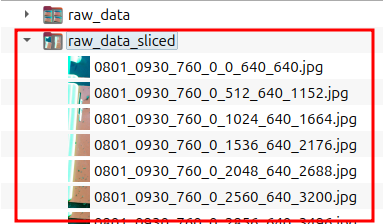
### 输出

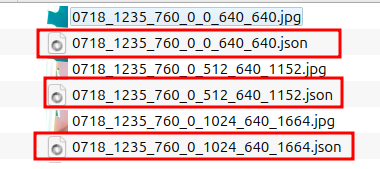

### 效果

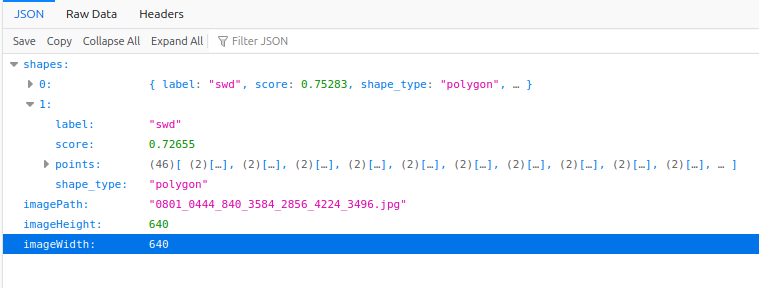


In [9]:
# Step 2 使用YOLO分割模型处理切片图像
from ultralytics import YOLO
from pathlib import Path
import os, gc
import orjson as jsonlib
import torch

def process_sliced_images_with_yolo_seg(chosen_dirs, model_path, COMMON_KWARGS):
    """
    使用YOLO模型处理切片图像并生成LabelMe格式的标注文件
    """
    model = YOLO(model_path)

    _dumps = lambda obj: jsonlib.dumps(obj, option=jsonlib.OPT_INDENT_2 | jsonlib.OPT_NON_STR_KEYS)
    _loads = jsonlib.loads

    for directory in chosen_dirs:
        print(f"\n=== 处理目录: {directory} ===")
        src_dir = Path(str(directory) + "_sliced")
        
        if not src_dir.exists() or not any(src_dir.iterdir()):
            print(f"跳过空目录: {src_dir}")
            continue

        # 获取所有图片文件
        image_files = list(src_dir.glob("*.jpg")) + list(src_dir.glob("*.png"))
        if not image_files:
            print(f"无图片: {src_dir}")
            continue

        # 分片处理避免内存溢出
        CHUNK_SIZE = 100
        for chunk_index in range(0, len(image_files), CHUNK_SIZE):
            image_chunk = image_files[chunk_index:chunk_index + CHUNK_SIZE]
            print(f" -> 处理分片 {chunk_index}-{chunk_index + len(image_chunk) - 1} / {len(image_files)}")

            # 批量预测
            results_generator = model.predict(image_chunk, **COMMON_KWARGS)

            # 逐图像处理结果
            for result_index, result in enumerate(results_generator, 1):
                try:
                    detections_list = _loads(result.to_json())

                    height, width = map(int, result.orig_shape[:2])
                    image_name = os.path.basename(getattr(result, "path", "")) or f"image_{result_index}.png"

                    shapes = []
                    for detection in detections_list:
                        segmentation = detection.get("segments", {})
                        xs, ys = segmentation.get("x", []), segmentation.get("y", [])
                        if not xs or not ys:
                            continue
                        points = [[float(x), float(y)] for x, y in zip(xs, ys)]
                        shapes.append({
                            "label": detection.get("name", ""),
                            "score": float(detection.get("confidence", 0.0)),
                            "points": points,
                            "shape_type": "polygon",
                        })

                    labelme_annotation = {
                        "shapes": shapes,
                        "imagePath": image_name,
                        "imageHeight": height,
                        "imageWidth": width,
                    }

                    output_path = src_dir / f"{Path(image_name).stem}.json"
                    output_path.write_bytes(_dumps(labelme_annotation))

                finally:
                    # 及时释放内存
                    del result
                    if result_index % 64 == 0:
                        torch.cuda.empty_cache()
                        gc.collect()

            # 分片结束后清理内存
            torch.cuda.empty_cache()
            gc.collect()

        print(f"✅ 完成。保存至: {src_dir}")

In [10]:
if "process_sliced_images_with_yolo_seg" in steps_to_run:
    seg_model_path = f"/workspace/models/best_model/yolo11n-seg-best.pt"
    COMMON_KWARGS = dict(
        imgsz=640,
        conf=0.25,
        iou=0.45,
        device=0,
        batch=3,
        retina_masks=False,
        workers=2,
        verbose=False,
        save=False,
    )
    process_sliced_images_with_yolo_seg(chosen_dirs, seg_model_path, COMMON_KWARGS  = COMMON_KWARGS)
else:
    print("跳过 Step 1: 使用YOLO分割模型标记掩码")


=== 处理目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data ===
 -> 处理分片 0-99 / 5481
 -> 处理分片 100-199 / 5481
 -> 处理分片 200-299 / 5481
 -> 处理分片 300-399 / 5481
 -> 处理分片 400-499 / 5481
 -> 处理分片 500-599 / 5481
 -> 处理分片 600-699 / 5481
 -> 处理分片 700-799 / 5481
 -> 处理分片 800-899 / 5481
 -> 处理分片 900-999 / 5481
 -> 处理分片 1000-1099 / 5481
 -> 处理分片 1100-1199 / 5481
 -> 处理分片 1200-1299 / 5481
 -> 处理分片 1300-1399 / 5481
 -> 处理分片 1400-1499 / 5481
 -> 处理分片 1500-1599 / 5481
 -> 处理分片 1600-1699 / 5481
 -> 处理分片 1700-1799 / 5481
 -> 处理分片 1800-1899 / 5481
 -> 处理分片 1900-1999 / 5481
 -> 处理分片 2000-2099 / 5481
 -> 处理分片 2100-2199 / 5481
 -> 处理分片 2200-2299 / 5481
 -> 处理分片 2300-2399 / 5481
 -> 处理分片 2400-2499 / 5481
 -> 处理分片 2500-2599 / 5481
 -> 处理分片 2600-2699 / 5481
 -> 处理分片 2700-2799 / 5481
 -> 处理分片 2800-2899 / 5481
 -> 处理分片 2900-2999 / 5481
 -> 处理分片 3000-3099 / 5481
 -> 处理分片 3100-3199 / 5481
 -> 处理分片 3200-3299 / 5481
 -> 处理分片 3300-3399 / 5481
 -> 处理分片 3400-3499 / 5481
 -> 处理分片 3500-3599 / 5481
 -> 处理分片 3600-36

# Step_3 0203  合并子图到大图。也将segmentation信息整合

### 输入输出
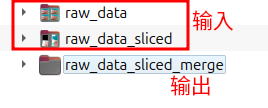

### 展开输出文件夹

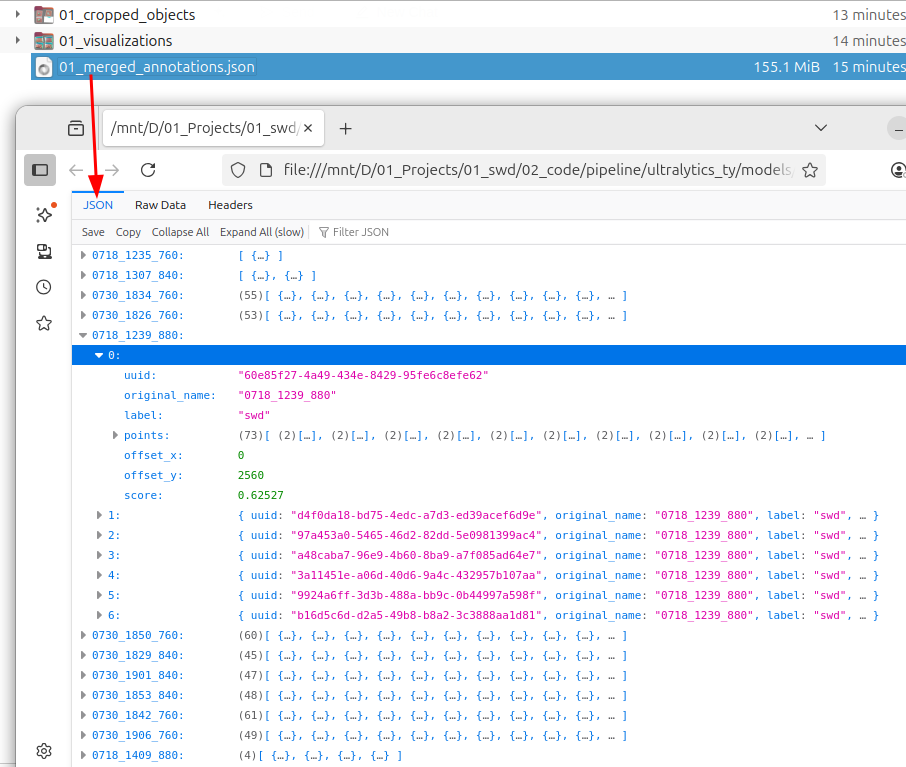


### 效果

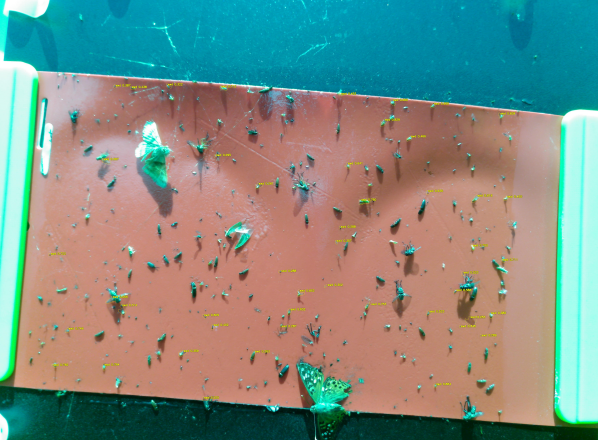

In [28]:
# Step 3 合并和去重切片预测结果
import os
import math
import uuid
from collections import defaultdict
from pathlib import Path
from typing import Optional, Iterable, List, Dict, Any, Tuple

import orjson
from tqdm import tqdm
import numpy as np
import cv2
from concurrent.futures import ProcessPoolExecutor, as_completed

# ============== JSON 工具函数 ==============
def json_load(path: str):
    with open(path, "rb") as f:
        return orjson.loads(f.read())

def json_dump(obj, path: str):
    with open(path, "wb") as f:
        f.write(orjson.dumps(obj, option=orjson.OPT_INDENT_2))

# ============== shapely（可选） ==============
try:
    from shapely.geometry import Polygon
    from shapely.ops import unary_union
    _HAVE_SHAPELY = True
except Exception:
    _HAVE_SHAPELY = False

# ============== 工具函数 ==============
def _build_image_index(original_image_dir: str) -> Dict[str, str]:
    """建立原图文件名到路径的索引"""
    idx: Dict[str, str] = {}
    for p in Path(original_image_dir).glob("*.jpg"):
        idx[p.stem] = str(p)
    return idx

def _draw_annotations_on_image(args: Tuple[str, List[Dict[str, Any]], str, str, bool, int]) -> bool:
    """在单张图像上绘制多边形标注"""
    image_name, annotations, image_path, out_dir, draw_text, jpeg_quality = args
    img = cv2.imread(image_path)
    if img is None:
        return False

    for ann in annotations:
        pts = np.asarray(ann["points"], dtype=np.int32).reshape(-1, 1, 2)
        cv2.polylines(img, [pts], isClosed=True, thickness=1, color=(0, 255, 255))

        if draw_text:
            label = ann.get("label", "")
            score = float(ann.get("score", 0.0))
            x0, y0 = int(ann["points"][0][0]) + 12, int(ann["points"][0][1]) + 12
            txt = f"{label} {score:.3f}"
            cv2.putText(img, txt, (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3, cv2.LINE_AA)
            cv2.putText(img, txt, (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)

    out_path = os.path.join(out_dir, f"{image_name}_vis.jpg")
    cv2.imwrite(out_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)])
    return True

def parse_slice_filename(filename: str):
    """解析切片文件名获取原图名和偏移坐标"""
    parts = Path(filename).stem.split("_")
    name = "_".join(parts[:-4])
    x1, y1, x2, y2 = map(int, parts[-4:])
    return name, x1, y1

# ============== 主要处理函数 ==============
def merge_slice_annotations(sliced_label_dir: str, output_json_path: str) -> Dict[str, List[Dict[str, Any]]]:
    """合并所有切片标注到原图坐标系"""
    merged_annotations: Dict[str, List[Dict[str, Any]]] = defaultdict(list)
    json_files = list(Path(sliced_label_dir).rglob("*.json"))

    for json_file in tqdm(json_files, desc="合并切片标注", unit="file"):
        data = json_load(str(json_file))
        image_path = data["imagePath"]
        original_name, offset_x, offset_y = parse_slice_filename(image_path)
        for shape in data.get("shapes", []):
            points = shape["points"]
            label = shape.get("label", "")
            new_points = [[x + offset_x, y + offset_y] for x, y in points]
            merged_annotations[original_name].append({
                "uuid": str(uuid.uuid4()),
                "original_name": original_name,
                "label": label,
                "points": new_points,
                "offset_x": offset_x,
                "offset_y": offset_y,
                "score": float(shape.get("score", 0.0)),
            })

    json_dump(merged_annotations, output_json_path)
    print(f"✅ 合并完成，共处理 {len(merged_annotations)} 张原图")
    print(f"✔️ 合并标注已保存到 {output_json_path}")
    return merged_annotations

def deduplicate_annotations(
    merged_annotations: Dict[str, List[Dict[str, Any]]],
    output_json_path: str,
    method: str = "GREEDYNMM",
    metric: str = "IOS",
    threshold: float = 0.5,
    class_agnostic: bool = False,
    center_threshold: Optional[float] = 20.0,
    keep_strategy: str = "REP"
) -> Dict[str, List[Dict[str, Any]]]:
    """去除重复标注（多种去重算法）"""
    
    # 内部工具函数定义
    def polygon_to_bbox(points: Iterable[Iterable[float]]) -> List[float]:
        xs, ys = zip(*points)
        return [min(xs), min(ys), max(xs), max(ys)]

    def bbox_area(bbox):
        w = bbox[2] - bbox[0]; h = bbox[3] - bbox[1]
        return (w if w > 0 else 0) * (h if h > 0 else 0)

    def bbox_iou(bbox_a, bbox_b):
        xA = max(bbox_a[0], bbox_b[0]); yA = max(bbox_a[1], bbox_b[1])
        xB = min(bbox_a[2], bbox_b[2]); yB = min(bbox_a[3], bbox_b[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        if inter <= 0: return 0.0
        u = bbox_area(bbox_a) + bbox_area(bbox_b) - inter
        return inter / u if u > 0 else 0.0

    def bbox_ios(bbox_a, bbox_b):
        xA = max(bbox_a[0], bbox_b[0]); yA = max(bbox_a[1], bbox_b[1])
        xB = min(bbox_a[2], bbox_b[2]); yB = min(bbox_a[3], bbox_b[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        if inter <= 0: return 0.0
        smaller = min(bbox_area(bbox_a), bbox_area(bbox_b))
        return inter / smaller if smaller > 0 else 0.0

    def center_distance(bbox_a, bbox_b):
        cxA = (bbox_a[0] + bbox_a[2]) * 0.5; cyA = (bbox_a[1] + bbox_a[3]) * 0.5
        cxB = (bbox_b[0] + bbox_b[2]) * 0.5; cyB = (bbox_b[1] + bbox_b[3]) * 0.5
        return math.hypot(cxA - cxB, cyA - cyB)

    match_metric = bbox_iou if metric.upper() == "IOU" else bbox_ios

    def is_same_group(ann1: Dict, ann2: Dict) -> bool:
        if (not class_agnostic) and (ann1["label"] != ann2["label"]):
            return False
        bbox1 = polygon_to_bbox(ann1["points"])
        bbox2 = polygon_to_bbox(ann2["points"])
        if (center_threshold is not None) and center_distance(bbox1, bbox2) > center_threshold:
            return False
        return match_metric(bbox1, bbox2) >= threshold

    def get_annotation_score(ann: Dict) -> float:
        try:
            return float(ann.get("score", 0.0))
        except Exception:
            return 0.0

    def select_representative_polygon(group: List[Dict]) -> Dict:
        best_ann = None
        best_key = (-1e9, -1e9)
        for i, ann in enumerate(group):
            bbox = polygon_to_bbox(ann["points"])
            overlap_sum = 0.0
            for j, other_ann in enumerate(group):
                if i == j: continue
                overlap_sum += match_metric(bbox, polygon_to_bbox(other_ann["points"]))
            key = (get_annotation_score(ann), overlap_sum)
            if key > best_key:
                best_key = key; best_ann = ann
        representative = dict(best_ann)
        representative["uuid"] = str(uuid.uuid4())
        return representative

    def merge_polygon_group(group: List[Dict]) -> Dict:
        if not _HAVE_SHAPELY:
            return select_representative_polygon(group)
        polygons = []
        for ann in group:
            points = ann["points"]
            if len(points) >= 3:
                try:
                    polygons.append(Polygon(points))
                except Exception:
                    pass
        if not polygons:
            return select_representative_polygon(group)
        merged_polygon = unary_union(polygons)
        if merged_polygon.geom_type == "MultiPolygon":
            merged_polygon = max(list(merged_polygon.geoms), key=lambda p: p.area)
        coordinates = list(merged_polygon.exterior.coords)[:-1]
        base_ann = dict(group[0])
        base_ann["uuid"] = str(uuid.uuid4())
        base_ann["points"] = [[float(x), float(y)] for (x, y) in coordinates] or group[0]["points"]
        base_ann["score"] = max(get_annotation_score(ann) for ann in group)
        return base_ann

    def process_annotation_group(group: List[Dict]) -> Dict:
        return merge_polygon_group(group) if keep_strategy.upper() == "UNION_POLY" else select_representative_polygon(group)

    # 去重算法实现
    def nms_algorithm(annotations: List[Dict]) -> List[Dict]:
        sorted_annotations = sorted(annotations, key=lambda a: get_annotation_score(a), reverse=True)
        kept_annotations: List[Dict] = []
        for ann in sorted_annotations:
            should_suppress = False
            ann_bbox = None
            for kept_ann in kept_annotations:
                if (not class_agnostic) and ann["label"] != kept_ann["label"]:
                    continue
                if ann_bbox is None:
                    ann_bbox = polygon_to_bbox(ann["points"])
                kept_bbox = polygon_to_bbox(kept_ann["points"])
                if (center_threshold is None or center_distance(ann_bbox, kept_bbox) <= center_threshold) and \
                   match_metric(ann_bbox, kept_bbox) >= threshold:
                    should_suppress = True; break
            if not should_suppress:
                kept_annotations.append(ann)
        result = []
        for ann in kept_annotations:
            new_ann = dict(ann); new_ann["uuid"] = str(uuid.uuid4())
            result.append(new_ann)
        return result

    def greedy_grouping_algorithm(annotations: List[Dict]) -> List[List[Dict]]:
        used = [False] * len(annotations)
        indices_sorted = sorted(range(len(annotations)), key=lambda i: get_annotation_score(annotations[i]), reverse=True)
        groups: List[List[Dict]] = []
        for idx in indices_sorted:
            if used[idx]: continue
            seed_ann = annotations[idx]
            group = [seed_ann]; used[idx] = True
            changed = True
            while changed:
                changed = False
                for j, other_ann in enumerate(annotations):
                    if used[j]: continue
                    if any(is_same_group(other_ann, group_ann) for group_ann in group):
                        group.append(other_ann); used[j] = True; changed = True
            groups.append(group)
        return groups

    # 主处理逻辑
    cleaned_annotations: Dict[str, List[Dict]] = {}
    total_before = sum(len(v) for v in merged_annotations.values())
    total_after = 0

    for image_name, annotations in tqdm(merged_annotations.items(), desc="去重处理", unit="image"):
        if not class_agnostic:
            label_buckets = defaultdict(list)
            for ann in annotations:
                label_buckets[ann["label"]].append(ann)
            result_annotations: List[Dict] = []
            for _, bucket in label_buckets.items():
                algorithm = method.upper()
                if algorithm == "NMS":
                    result_annotations.extend(nms_algorithm(bucket))
                elif algorithm == "NMM":
                    result_annotations.extend(process_annotation_group(g) for g in pairwise_grouping(bucket))
                elif algorithm == "LSNMS":
                    result_annotations.extend(lsnms_algorithm(bucket))
                else:  # GREEDYNMM
                    result_annotations.extend(process_annotation_group(g) for g in greedy_grouping_algorithm(bucket))
        else:
            algorithm = method.upper()
            if algorithm == "NMS":
                result_annotations = nms_algorithm(annotations)
            elif algorithm == "NMM":
                result_annotations = [process_annotation_group(g) for g in pairwise_grouping(annotations)]
            elif algorithm == "LSNMS":
                result_annotations = lsnms_algorithm(annotations)
            else:
                result_annotations = [process_annotation_group(g) for g in greedy_grouping_algorithm(annotations)]

        cleaned_annotations[image_name] = result_annotations
        total_after += len(result_annotations)

    json_dump(cleaned_annotations, output_json_path)

    print(f"🔁 去重完成（{method}, metric={metric}, threshold={threshold}, class_agnostic={class_agnostic}, strategy={keep_strategy}）")
    print(f"    目标数：{total_before} → {total_after}")
    if keep_strategy.upper() == "UNION_POLY" and not _HAVE_SHAPELY:
        print("⚠️ 未安装shapely，已退回REP模式")
    print(f"✔️ 已保存到 {output_json_path}")
    return cleaned_annotations

def visualize_annotations(
    merged_annotations: Dict[str, List[Dict[str, Any]]],
    original_image_dir: str,
    output_visual_dir: str,
    draw_text: bool = True,
    jpeg_quality: int = 95,
    parallel: bool = True,
    max_workers: Optional[int] = None
):
    """可视化标注结果"""
    os.makedirs(output_visual_dir, exist_ok=True)
    image_index = _build_image_index(original_image_dir)

    tasks = []
    for image_name, annotations in merged_annotations.items():
        image_path = image_index.get(image_name)
        if image_path is None or not os.path.exists(image_path):
            found = None
            for p in Path(original_image_dir).glob(f"{image_name}*.jpg"):
                found = str(p); break
            image_path = found
        if image_path is None or not os.path.exists(image_path):
            continue
        tasks.append((image_name, annotations, image_path, output_visual_dir, draw_text, jpeg_quality))

    if not tasks:
        print("⚠️ 没有可视化任务")
        return

    if not parallel:
        for task in tqdm(tasks, desc="可视化处理（串行）", unit="image"):
            _draw_annotations_on_image(task)
    else:
        if max_workers is None:
            max_workers = max(2, (os.cpu_count() or 8) // 2)
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(_draw_annotations_on_image, task) for task in tasks]
            for _ in tqdm(as_completed(futures), total=len(futures), desc="可视化处理（并行）", unit="image"):
                pass

    print(f"🖼 可视化图片已保存到 {output_visual_dir}/")

def _crop_single_object(args: Tuple[str, List[Dict[str, Any]], str, str, int, int]) -> int:
    """裁剪单个目标对象"""
    image_name, annotations, image_path, out_dir, margin, jpeg_quality = args
    img = cv2.imread(image_path)
    if img is None:
        return 0
    height, width = img.shape[:2]
    saved_count = 0

    for idx, ann in enumerate(annotations):
        points = np.asarray(ann["points"], dtype=np.float32)
        xs = points[:, 0]; ys = points[:, 1]
        min_x, max_x = float(xs.min()), float(xs.max())
        min_y, max_y = float(ys.min()), float(ys.max())

        bbox_width = max_x - min_x
        bbox_height = max_y - min_y
        side_length = max(bbox_width, bbox_height)

        center_x = (min_x + max_x) * 0.5
        center_y = (min_y + max_y) * 0.5

        left = int(round(center_x - side_length * 0.5)) - margin
        top = int(round(center_y - side_length * 0.5)) - margin
        right = int(round(center_x + side_length * 0.5)) + margin
        bottom = int(round(center_y + side_length * 0.5)) + margin

        left = max(0, left)
        top = max(0, top)
        right = min(width, right)
        bottom = min(height, bottom)

        if right - left <= 1 or bottom - top <= 1:
            continue

        crop = img[top:bottom, left:right]
        save_name = f"{image_name}_obj{idx}_{ann.get('label','')}_uuid_{ann['uuid']}.jpg"
        out_path = os.path.join(out_dir, save_name)
        cv2.imwrite(out_path, crop, [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)])
        saved_count += 1

    return saved_count

def export_cropped_objects(
    merged_annotations: Dict[str, List[Dict[str, Any]]],
    original_image_dir: str,
    cropped_object_dir: str,
    margin: int = 0,
    jpeg_quality: int = 95,
    parallel: bool = True,
    max_workers: Optional[int] = None
):
    """导出裁剪的目标对象"""
    os.makedirs(cropped_object_dir, exist_ok=True)
    image_index = _build_image_index(original_image_dir)

    tasks = []
    for image_name, annotations in merged_annotations.items():
        image_path = image_index.get(image_name)
        if image_path is None or not os.path.exists(image_path):
            found = None
            for p in Path(original_image_dir).glob(f"{image_name}*.jpg"):
                found = str(p); break
            image_path = found
        if image_path is None or not os.path.exists(image_path):
            continue
        tasks.append((image_name, annotations, image_path, cropped_object_dir, margin, jpeg_quality))

    total_saved = 0
    if not tasks:
        print("⚠️ 没有可导出的裁剪任务")
        return

    if not parallel:
        for task in tqdm(tasks, desc="导出裁剪（串行）", unit="image"):
            total_saved += _crop_single_object(task)
    else:
        if max_workers is None:
            max_workers = max(2, (os.cpu_count() or 8) // 2)
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(_crop_single_object, task) for task in tasks]
            for future in tqdm(as_completed(futures), total=len(futures), desc="导出裁剪（并行）", unit="image"):
                total_saved += future.result()

    print(f"📦 个体裁剪图像已保存到 {cropped_object_dir}/ （共导出 {total_saved} 张）")



In [29]:
def combine_sliced_predictions(chosen_dirs):
    """处理切片预测结果的主函数"""
    for directory in chosen_dirs:
        print(f"\n=== 处理目录: {directory} ===")
        original_image_dir = str(directory)
        sliced_label_dir = str(directory) + "_sliced"
        output_json_path = str(directory) + "_sliced_merge/01_merged_annotations.json"
        output_visual_dir = str(directory) + "_sliced_merge/01_visualizations"
        cropped_object_dir = str(directory) + "_sliced_merge/01_cropped_objects"

        print(f"原图目录: {original_image_dir}")
        print(f"切片标注目录: {sliced_label_dir}")
        print(f"输出合并标注: {output_json_path}")
        print(f"输出可视化目录: {output_visual_dir}")
        print(f"输出裁剪目录: {cropped_object_dir}")

        os.makedirs(output_visual_dir, exist_ok=True)
        os.makedirs(cropped_object_dir, exist_ok=True)

        # 1) 合并切片标注
        merged_annotations = merge_slice_annotations(sliced_label_dir, output_json_path)

        # 2) 去重处理
        merged_annotations = deduplicate_annotations(
            merged_annotations,
            output_json_path,
            method="NMS",               # 'NMM'/'GREEDYNMM'/'LSNMS'/'NMS' -- NMS每个目标最多 1 个重复（完整 + 小碎片），直接保留高分的那一个就行。
            metric="IOS",               # 'IOU'/'IOS'  当可能出现"小框被大框包含"时，推荐使用 IOS，当两个框大小相近，且你想知道"整体重叠程度"时，推荐使用 IOU
            threshold=0.5,              # 两个边界框被认为是重复的阈值
            class_agnostic=False,
            center_threshold=20,
            keep_strategy="REP"         # 'REP'/'UNION_POLY' -- 不需要 UNION_POLY（并集）去“粘合碎片”，因为我们只保留完整的那份就好。
        )

        # 3) 可视化
        visualize_annotations(
            merged_annotations,
            original_image_dir,
            output_visual_dir,
            draw_text=True,         # 是否绘制标签和置信度，关掉可以提升速度
            jpeg_quality=95,
            parallel=True,
            max_workers=None
        )

        # 4) 导出裁剪
        export_cropped_objects(
            merged_annotations,
            original_image_dir,
            cropped_object_dir,
            margin=15,
            jpeg_quality=95,
            parallel=True,
            max_workers=None
        )

In [30]:
if "combine_sliced_predictions" in steps_to_run:
    combine_sliced_predictions(chosen_dirs)
else:
    print("跳过 Step 2: 合并和去重切片预测结果")


=== 处理目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data ===
原图目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data
切片标注目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced
输出合并标注: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_merged_annotations.json
输出可视化目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_visualizations
输出裁剪目录: /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects


合并切片标注:   0%|          | 0/5481 [00:00<?, ?file/s]

合并切片标注: 100%|██████████| 5481/5481 [00:01<00:00, 2876.40file/s]


✅ 合并完成，共处理 87 张原图
✔️ 合并标注已保存到 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_merged_annotations.json


去重处理: 100%|██████████| 87/87 [00:00<00:00, 171.64image/s]


🔁 去重完成（NMS, metric=IOS, threshold=0.5, class_agnostic=False, strategy=REP）
    目标数：8679 → 5900
✔️ 已保存到 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_merged_annotations.json


可视化处理（并行）: 100%|██████████| 87/87 [00:01<00:00, 54.17image/s]


🖼 可视化图片已保存到 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_visualizations/


导出裁剪（并行）: 100%|██████████| 87/87 [00:04<00:00, 19.12image/s]


📦 个体裁剪图像已保存到 /workspace/models/SAHI/run_v8/ms1_0726-0809_11/raw_data_sliced_merge/01_cropped_objects/ （共导出 5900 张）
